<a href="https://colab.research.google.com/github/josh-ashkinaze/Google-profanity-words/blob/master/Reddit_Relationships_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Outline of Analysis 

I have three main research questions. 



1.   What are latent topics that people post about?
2.   Do people post different things during different seasons?
3.   What are the topics associated with different relationship partners?

Finally, I want to build a model to predict the number of upvotes. 






# Explore DataFrame

## Install packages

> Install dependencies for analysis



In [0]:
#Install
!pip install nltk
!pip install textblob

# Utilities 
import re
import string 
from IPython.display import display, clear_output
import numpy as np
import pandas as pd

# NLP Libraries 
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn import feature_selection
from sklearn.pipeline import Pipeline
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# Graphing libraries 
import seaborn as sns 
import warnings
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
warnings.filterwarnings('ignore')

nltk.download("stopwords")
nltk.download('punkt')
clear_output()

## Read in dataframe

In [2]:
# upload file 
from google.colab import files
files.upload()



Saving relationships1000.csv to relationships1000.csv


{'relationships1000.csv': b',author,flair,post_id,score,self_txt,timestamp,title,upvote_ratio\n0,itsme2213,Updates,a72pyo,14488,"Original post is here: [https://www.reddit.com/r/relationships/comments/9cx874/im\\_28f\\_unsure\\_if\\_its\\_time\\_to\\_draw\\_boundaries\\_with/](https://www.reddit.com/r/relationships/comments/9cx874/im_28f_unsure_if_its_time_to_draw_boundaries_with/)\n\nTLDR of original: My boyfriend has become fast friends with a female coworker. She and her fianc? are now moving into our apartment building, and my boyfriend is seeing and talking to her more and more. I don\'t know if it\'s time to set boundaries or if I\'m getting ahead of myself.\n\n&#x200B;\n\nA lot has happened since my last post, and I got some good advice there, so I wanted to post an update!\n\nAfter I made the last post I came home from the trip with my family a couple of days later. I told my boyfriend that I wanted to talk to him about something and I brought up his friendship with Liz. I basi

## Inspect dataframe

Let's look at the head, tail, length, and columns. 
Let's make sure there aren't too many missing values. 

In [3]:
# Read in csv
df = pd.read_csv("relationships1000.csv")

# Examine structure
print("Head", df.head(5))
print("Tail", df.tail(5))
print("Length", len(df))

# Take a look at columns 
print(df.dtypes, "\n")

# Check for null values in columns
null_columns = df.columns[df.isnull().any()]
empty = df.loc[df['self_txt'].isnull()]
print("Post with no self text: \n \n", str(empty['title']))

# Since it's just one post, and we want to use self_text, let's drop it. 
df.dropna(subset=['self_txt'], inplace=True)



Head    Unnamed: 0  ... upvote_ratio
0           0  ...         0.98
1           1  ...         0.95
2           2  ...         0.98
3           3  ...         0.97
4           4  ...         0.98

[5 rows x 9 columns]
Tail      Unnamed: 0  ... upvote_ratio
884         884  ...         0.95
885         885  ...         0.92
886         886  ...         0.96
887         887  ...         0.97
888         888  ...         0.96

[5 rows x 9 columns]
Length 889
Unnamed: 0        int64
author           object
flair            object
post_id          object
score             int64
self_txt         object
timestamp       float64
title            object
upvote_ratio    float64
dtype: object 

Post with no self text: 
 
 387    Me [28F] with my [29F] co-worker, she doesn't ...
Name: title, dtype: object


## Add features

Let's tag the season of a post and the subject. 

In [4]:
# Now we want to add some features. In particular, we want to add:
# 1. Subject of posts
# 2. Season of posts


def parse_date(df):
  """
  Parses a UNIX timestamp - 
  Creates year, month, day, and hour as features
  """
  df['date'] = pd.to_datetime(df['timestamp'],unit='s', utc=True)
  df['year'] = pd.DatetimeIndex(df['date']).year  
  df['month'] = pd.DatetimeIndex(df['date']).month
  df['day'] = pd.DatetimeIndex(df['date']).dayofweek + 1 # make weekday start at 1 (Week starts on Monday)
  df['hour'] = pd.DatetimeIndex(df['date']).hour + 1 #make hour start at 1
  return df 

def tag_seasons(df):
  df.loc[(df['month'] == 12)|(df['month'] == 1)|(df['month'] == 2), 'season'] = 'Winter'
  df.loc[(df['month'] == 9)|(df['month'] == 10)|(df['month'] == 11), 'season'] = 'Autumn'
  df.loc[(df['month'] == 3)|(df['month'] == 4)|(df['month'] == 5), 'season'] = 'Spring'
  df.loc[(df['month'] == 6)|(df['month'] == 7)|(df['month'] == 8), 'season'] = 'Summer'
  return df

# Parse date and tag seasons
df = parse_date(df)
df = tag_seasons(df)

# Assign partners based on title 
df.loc[df['title'].str.contains('girlfriend|gf'), 'subj'] = 'GF'
df.loc[df['title'].str.contains('boyfriend|bf'), 'subj'] = 'BF'
df.loc[df['title'].str.contains('husband'), 'subj'] = 'Husband'
df.loc[df['title'].str.contains('wife'), 'subj'] = 'Wife'

subj_df = pd.value_counts(df.subj).to_frame().reset_index()
print(subj_df)
# Let's make sure this all worked out 
print(df.head())



     index  subj
0       BF   130
1  Husband   105
2       GF   103
3     Wife    74
   Unnamed: 0                author         flair  ... hour  season     subj
0           0             itsme2213       Updates  ...   20  Winter       BF
1           1  whenlifegivesyoushit       Updates  ...   21  Summer  Husband
2           2     AggressiveImpact7       Updates  ...   22  Winter      NaN
3           3            LadyGrey90  Non-Romantic  ...   13  Spring      NaN
4           4     AbandonedTraveler       Updates  ...   16  Autumn       BF

[5 rows x 16 columns]


## Descriptive statistics and visualizations

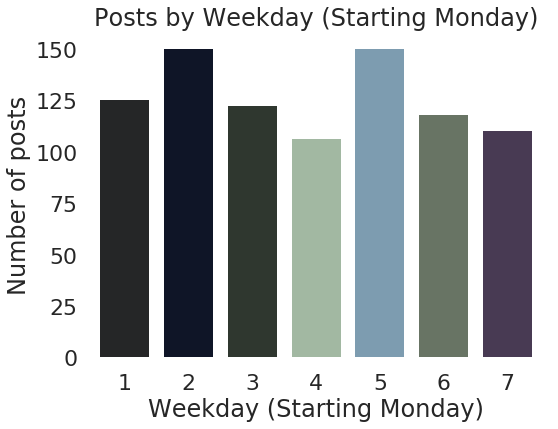

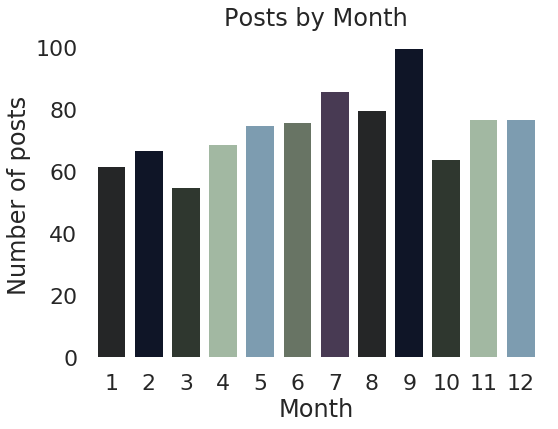

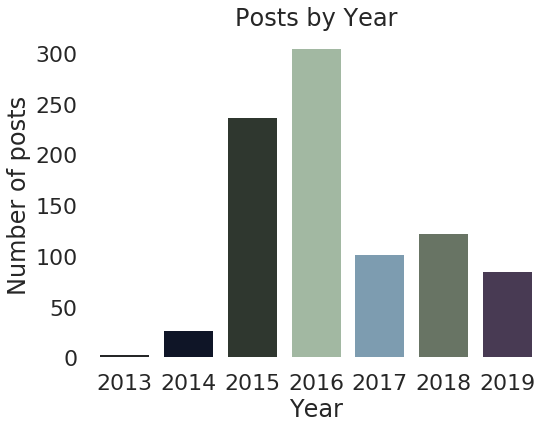

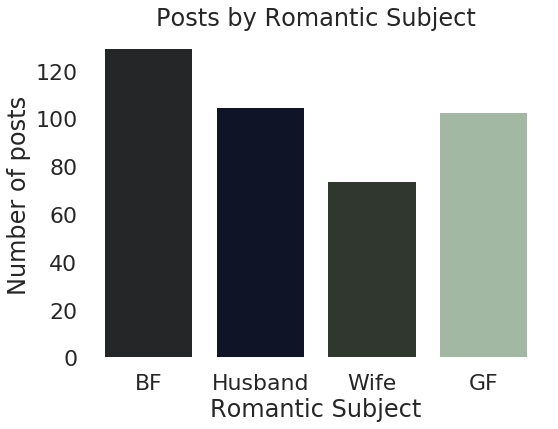

count    888.000000
mean       0.949505
std        0.027541
min        0.740000
25%        0.940000
50%        0.960000
75%        0.970000
max        0.990000
Name: upvote_ratio, dtype: float64


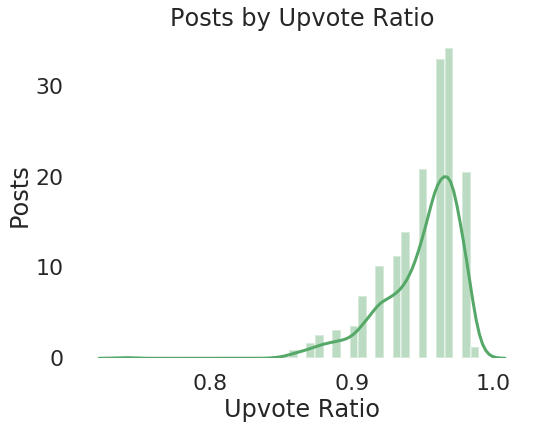

count      888.000000
mean      2814.560811
std       1406.610766
min       1651.000000
25%       1925.000000
50%       2333.500000
75%       3178.750000
max      14488.000000
Name: score, dtype: float64


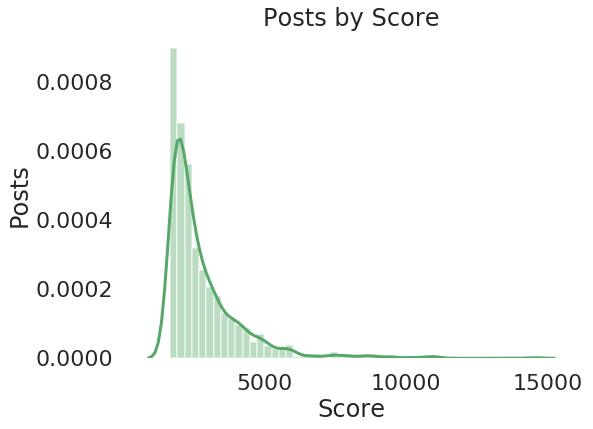

In [5]:
import seaborn as sns 
import warnings
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
warnings.filterwarnings('ignore')

# Wanted palette details

my_colors = ["#252627", "#0B132B", "#2E382E", "#9EBC9E", "#759EB8", "#667761", "#493657"]
sns.set_palette(palette=my_colors)
plt.rcParams["patch.force_edgecolor"] = False


def countplot(df, var, label):
  sns.set(style="white")
  sns.set_context("poster")
  plt.figure(figsize=(8,6))
  filename = "{}{}.png".format("count", var)
  plot = sns.countplot(x=var, data=df, palette=my_colors)
  sns.despine(left=True, bottom=True, top=True, right=True)
  plt.xlabel(label)
  plt.ylabel("Number of posts")
  plt.title("Posts by {}".format(label))
#   plt.savefig(filename, dpi=300, bbox_inches="tight", transparent=True)
#   files.download(filename)
  plt.show()
  plt.close("all")
  


def distplot(df, var, label): 
  sns.set(style="white")
  sns.set_context("poster")
  plt.figure(figsize=(8,6))
  filename = "{}{}.png".format("dist", label)
  plot = sns.distplot(df[var], color="C2")


  sns.despine(left=True, bottom=True, top=True, right=True)
  plt.xlabel(label)
  plt.ylabel("Posts")
  plt.title("Posts by {}".format(label))
#   plt.savefig(filename, dpi=300, bbox_inches="tight", transparent=True)
#   files.download(filename)
  plt.show()
  plt.close("all")


  
  

# Make countplots 

countplot_labels = {
          'day': 'Weekday (Starting Monday)', 
          'month':'Month', 
          'year':'Year',
          'subj': 'Romantic Subject'
}
for var in countplot_labels:
  countplot(df, var, countplot_labels[var])
  
  
  
  
# Make distplots

distplot_labels = {
          'upvote_ratio': 'Upvote Ratio', 
          'score':'Score'
}
for var in distplot_labels:
  print(df[var].describe())
  distplot(df, var, distplot_labels[var])


  


# Define functions for text mining 

##  Cleaning text

In [0]:
# Returns a tokenized form of a string 

def preprocess(docs, settings):
  """ 
  Clean and tokenize text document
  """
  clean_docs = [clean_text(i, settings) for i in docs]
  clean_docs = [tokenize(i, settings) for i in clean_docs]

  return clean_docs

def tokenize(text, settings):
  """ 
  Tokenizes text -- returning the tokens as a string 
  """
  nltk_tokenizer = nltk.WordPunctTokenizer().tokenize
  tokens = nltk_tokenizer(text)  
  result =  [i for i in tokens if len(i)>settings['min_len']]
  result = " ".join(result)
  
  return result


def clean_text(text, settings): 
  """ 
  Cleans text -- 
  
  Removes case, removes punctuation,
  removes stopwords, and removes numbers (if specified. 
  """
  new_text = make_lowercase(text)
  new_text = remove_punct(new_text)
  if settings['keep_numbers'] is False: 
    new_text = remove_numbers(new_text)
  new_text = remove_stopwords(new_text, settings)
  return new_text

def correct_spelling(text):
  new_text = str(TextBlob(text).correct())
  return new_text

def make_lowercase(text):
  new_text = text.lower()
  return new_text

def remove_numbers(text):
  new_text = ''.join([i for i in text if not i.isdigit()])
  return new_text

def remove_stopwords(text, settings):
  stop_words = set(stopwords.words("english")).union(settings['custom_stopwords'])
  new_text = ' '.join([i for i in text.split() if not i in stop_words])
  return new_text

def remove_punct(text: str) -> str:
    for p in string.punctuation:
        text = text.replace(p, '')
    return text



## Creating topics

In [0]:

def print_topic_dist(W, labels=None, title=None):
  """
  Creates graph of NMF topic distribution  
  """
  
  # Note: Assigning a topic to a post is a little handwavy. 
  # Every post is some linear combination of topics, so 
  # I take the argmax of the weights. In other words, 
  # If post X's largest weight corresponds to topic A, 
  # then I assign topic A to post X. 
  
  topics = pd.DataFrame(W).idxmax(axis=1, skipna=True).tolist()
  dfW = pd.DataFrame(topics, columns=['topic'])
  
  # Plot settings 
  sns.set(style="white")
  sns.set_context("poster")
  plt.figure(figsize=(8,6))
  filename = "NMF"
  
  # Make plot with labels 
  a = sns.countplot(y='topic', data=dfW, palette=my_colors)
  if labels:
    a.set_yticklabels(labels)
  a.set(xlabel="Number of Posts")
  a.set(ylabel="Topic")
  if title:
    plt.title(title)

  sns.despine(left=True, bottom=True, top=True, right=True)
  plt.savefig("topics.png", dpi=500, bbox_inches="tight", transparent=True)
  files.download("topics.png")
  plt.show()
  plt.close()
  return df

  

def display_topics(H, W, feature_names, df, no_top_words, no_top_documents):
  """ 
  Provides info on topic model by printing words 
  associated with topic and representative documents. 
  """
  for topic_idx, topic in enumerate(H):
      print ("Topic {}: ".format(topic_idx)  + ",".join(
          [feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))
      top_doc_indices = np.argsort( W[:,topic_idx] )[::-1][0:no_top_documents]
      for idx in top_doc_indices:
          print (df['title'].tolist()[idx])
      print()

            
# Build a topic analysis model 
def make_topics(df, clean_docs, settings):
  """ 
  Build a topic analysis model --
  
  Using a TF-IDF vectorizer and an NMF model
  for dimensionality reduction. 
  """
  no_topics = settings['n_topics'] # hypothesized latent topics 
  no_top_words = settings['n_top_words'] # number of sample words per topic 
  no_top_documents = settings['n_top_docs'] # number of docs to print per topic 
  ngram = settings['ngram']
  max_df = settings['max_df']
  
  # Fit a TFIDF vectorizer 
  tfidf_vectorizer = TfidfVectorizer(
                                     max_df=max_df,
                                     min_df = 5,
                                     stop_words='english', 
                                     ngram_range = (ngram[0], ngram[1])
  )
  
  tfidf = tfidf_vectorizer.fit_transform(clean_docs)
  tfidf_feature_names = tfidf_vectorizer.get_feature_names()

  # Run NMF
  nmf_model = NMF(n_components=no_topics,
                  random_state=1, 
                  alpha=0.000001, 
                  init='nndsvd').fit(tfidf)
  
  nmf_W = nmf_model.transform(tfidf)
  nmf_H = nmf_model.components_
  
 
  # Display topics 
  display_topics(nmf_H, nmf_W, tfidf_feature_names, df, no_top_words, no_top_documents)
  return nmf_W, nmf_H




# Topic Mining Analysis 

## Q1: What are the latent topics in the data?

Cleaned. 

Topic 0: dont,know,sister,family,brother,deal,daughter
UPDATE: I [23/F] don't know whether my SO [24/M] of two year's appearance-related "preferences" cross the line.
[Update]Friend [37/F] is about to be turned-down for a promotion she has dreamed of for years. I [36/F] know it's coming and don't know how to support her or what to do.
(update!) My girlfriend [29F] introduced me to her son [13M] and I don't know if I want to parent him
UPDATE Me [30F] with my BF [30M] duration, I want to send him sexy pictures as a surprise but I don't know if I should.
Friend [37/F] is about to be turned-down for a promotion she has dreamed of for years. I [36/F] know it's coming and don't know how to support her or what to do.
UPDATE: My (28M) pregnant wife (26F) has gonorrhea and I don't know what to do
[Update] "Me [27 F] with my BF [28 M] of seven years. I don't know what I did wrong..."

Topic 1: boyfriend,year,feel,months,friends,years,break
[Update] Boyfriend [25M] and his sister-in-l

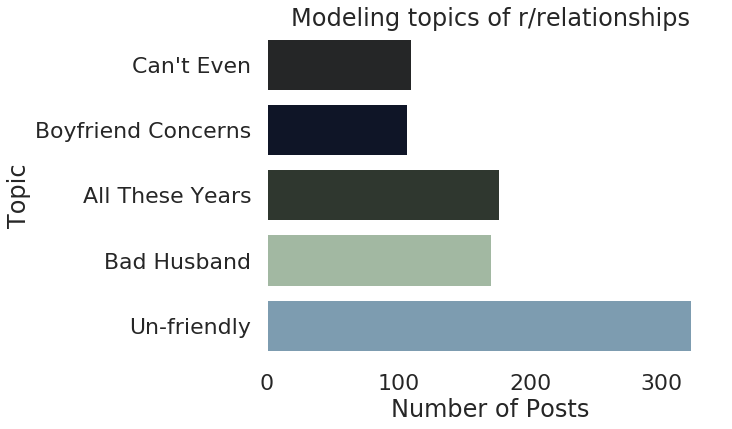

In [8]:

clean_settings = {
         "min_len": 2,
         "keep_numbers": False,
          "custom_stopwords":{
                             'told',
                             'post',
                             "wants",
                             "want",
                             "update"
  }
}
 
  
  

  
topic_settings = {"n_topics": 5, 
                  "n_top_words": 7, 
                  "max_df": 0.8,
                  "n_top_docs": 7, 
                  "ngram": [1,1]            
}
  
# Get a list of titles  
my_df = df.dropna(subset=['title'])
documents = my_df['title'].tolist()
clean_docs = preprocess(documents, clean_settings)
print("Cleaned. \n")

# Build topic model x
labels = ["Can't Even", "Boyfriend Concerns", "All These Years", "Bad Husband", "Un-friendly"]
W, H = make_topics(df, clean_docs, topic_settings)
topic_df = print_topic_dist(W, labels, "Modeling topics of r/relationships")




Let's look at late night topics. 

Now we'll look at early topics. 

In [0]:

# This will be vectorizer we use to rank terms 
def create_vectorizer(clean_docs, n_words, ngram):
  """
  Crate a TF-IDF vectorizer
  """
  vect = TfidfVectorizer(max_df=0.99,  max_features=n_words, stop_words='english',ngram_range=(ngram, ngram))
  return vect

def rank_terms(clean_docs, vect):
  """
  Returns the results of a TF-IDF vectorizer in a dataframe
  """
  tfidf_result = vect.fit_transform(clean_docs)
  sums = tfidf_result.sum(axis=0)
  terms = vect.get_feature_names()
  data = []
  for col, term in enumerate(terms):
    data.append( (term, sums[0,col] ))
  df = pd.DataFrame(data, columns=['term','rank'])
  df.sort_values("rank", ascending=False, inplace=True)
  return df

def graph_terms(clean_docs, n_words, ngram):
  """
  Graphs results from a TF-iDF vectorizer 
  """
  plt.figure(figsize=(8,11))
  sns.set_context("poster")
  sns.set_style='White'
  vect = create_vectorizer(clean_docs, n_words, ngram)
  df = rank_terms(clean_docs, vect)
  print(df)
  sns.barplot(data=df, y='term', x='rank', palette="Set2")
  sns.despine(left=True, right=True, bottom=True, top=True)
  plt.title("Importance")
  plt.ylabel("Term")
  plt.xlabel("Frequency in r/relationships posts \ndivided by frequency in English language")
  plt.show()
  
  
clean_settings = {
         "min_len": 4,
         "keep_numbers": False,
          "custom_stopwords":{
                             'told',
                             'dont',
                             'got',
                             "family", 
                             "update",
                             "doesent", "didnt", "wasnt",
                             'post',"posts"
                             "want", "wants"
                             "update", 
                             "updates", 
                              "really", "going", "think"
                              "relationship", "girlfriend", "things",
                             "boyfriend", "husband", "wife", "wanted", "think",
                             "year", "years"
  }
}
 

 Now we're going to loop through subjects and try to find the right number of topics. After that, let's  record the optial number of topics and graph the distribution of topics per subject. 


******************** BF ******************** 
 

Topic 0: months,relationship,broke,original,dating,needed,started,thank,ended,thought
UPDATE: Every year, my boyfriend (21M) and I (22F) go on a ?break? because he doesn?t know what he wants
Update "Me [27 F] heartbroken after my [26 M] boyfriend of 6 years backs out of planned proposal"
Update from original post of my bf (24M) not wanting me (22F) to take antidepressants.
[UPDATE]Me [21 F] engaged after 2 months of knowing each other and dating with my boyfriend [20 M] duration, short-description
[UPDATE] My [28F] boyfriend [27M] of three years refused to pull over while he was driving, pissed himself, and then kinda blamed me for it.

Topic 1: friends,friend,close,girls,asked,doesnt,apartment,relationship,started,weekend
Update: I [27f] dumped my boyfriend [27m] for using cocaine. Now his friends hate me.
My [24F] sister [25F] and her bf [25M] are upset because my fiance [27M] proposed to me and have started shaming us on social media


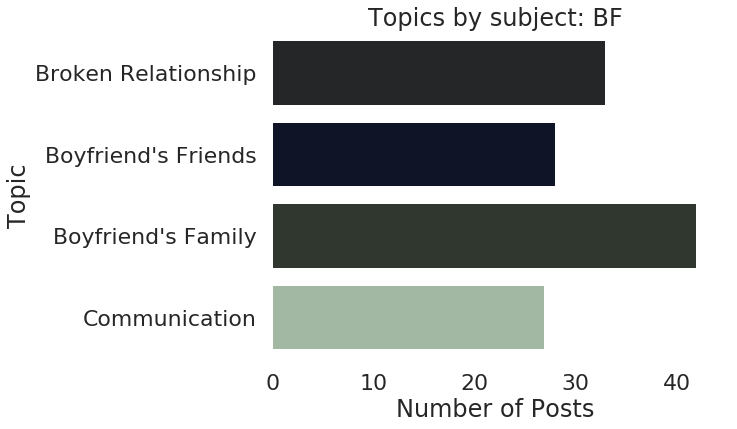

******************** HUSBAND ******************** 
 

Topic 0: better,thank,right,needed,little,advice,thing,actually,helped,issues
[UPDATE] My [36F] husband [39M] of 13 years is against having our cat euthanized; implies I want to 'murder' the cat for being an 'inconvenience'
[Update] My (31F) husband's (32M) mother (60sF) has Alzheimers. He moved her in with us and is not actively looking for a nursing home. My house is a mess and I am at my wits end
Update: How do I [26F] tell my husband [31M] I'm addicted to drugs?
[UPDATE] My [23F] husband's [28M] father [60'sM] died and now my husband is an absolute monster.
[Update] Me [33F] and my husband [34M], together for 10 years ? He is uncomfortable with how often I touch him

Topic 1: sister,sisters,house,parents,daughter,brother,money,later,moved,apartment
My sister [32] and her husband [30] are getting evicted from their apartment, and my mom [65] and dad [67] thinks that I [40M] should let them live in my beach house for free
[UPDATE]

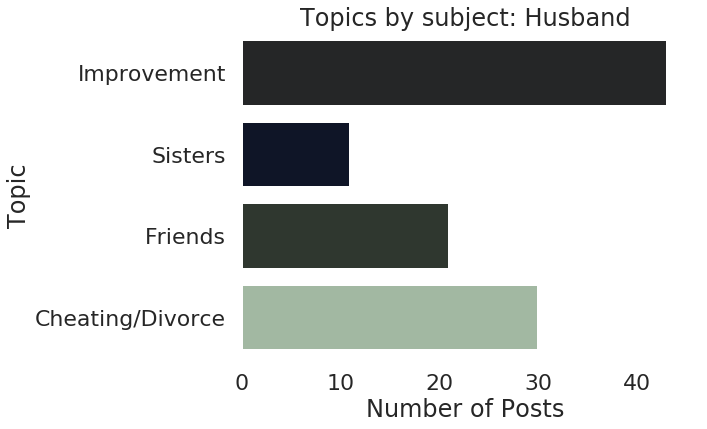

******************** WIFE ******************** 
 

Topic 0: asked,right,talked,friends,thought,friend,pretty,advice,happened,pictures
Me [30M] and my wife [36F] of 5 years, have been dealing with my obsessed ex-gf [28F] for years, but it has now started to affect my wife negatively
Update - My injured wife[27-f] of 3 years just told me[25-m] to start sleeping with other women. [NSFW]
I (31M) found out my wife (30F) has been getting a coworker (29F) to spy on me at work.
[UPDATE] My [24F] mum [54F] has not seen my dad [52M] since their messy divorce, nor met the OW/his new wife [42F] [...] they are all attending my graduation where they will also meet my bf's [23M] parents for the first time. (!!!)
[Update] My [28M] friends/co-workers [20s M/F] are mocking my wife [22F] and our arranged marriage, not sure how to address or deal with this?

Topic 1: daughter,daughters,needs,college,clothes,sister,money,times,called,month
My (M/47) wife (F/39) has kicked our daughter (F/19) out of my hous

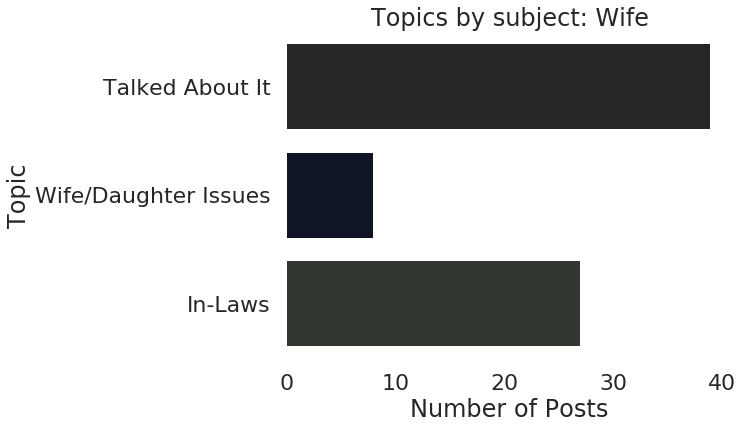

******************** GF ******************** 
 

Topic 0: friends,friend,asked,started,cheating,night,people,couple,person,point
[UPDATE] I [22M] suspect something between my girlfriend [22F] and my friend [21M]. We all live together. Am I imagining things?
[FINAL UPDATE] I [21M] was raped. My girlfriend [22F] of 3 years accused me of cheating when I told her. Don't know where to go from here.
UPDATE: My [28F] girlfriend and I [38F] got into a fight. She posted a long "apology" letter on a social media website and it really pisses me off.
[UPDATE 2] I [22M] suspect something between my girlfriend [22F] and my friend [21M]. We all live together. Am I imagining things?
UPDATE: I [28f] literally just found email after email from my fianc? [27m] to his ex girlfriend [20s/f] belittling and making fun of me and worse. Seriously shocked beyond belief right now.

Topic 1: sister,photo,house,sisters,saying,scared,apparently,night,morning,college
My sister [20F] described to me a really weird an

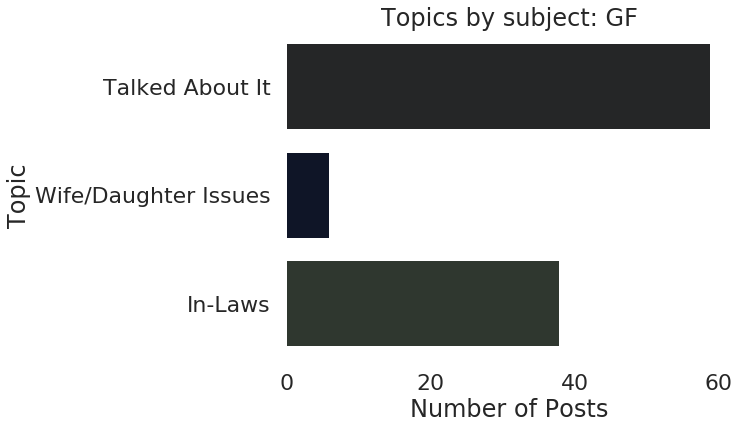

In [20]:

# LOOP THROUGH SUBJECTS 


# n_topics = [3, 4, 5]
# topic_settings['n_top_words'] = 10
# topic_settings['n_top_docs'] = 5
# topic_settings['ngram'] = [1,1]

# for subj in ("BF", "Husband", "Wife", "GF"):
#   print( "*"*20, subj.upper(), "*"*20, "\n \n")
#   mydf = df.loc[(df['subj'] == subj)]
#   docs = mydf['self_txt'].tolist()
#   clean_docs = preprocess(docs, clean_settings)
#   for n in n_topics:
#     print("TESTING {} TOPICS \n".format(n))
#     topic_settings['n_topics'] = n
#     W, H = make_topics(mydf, clean_docs, topic_settings)
#     print_topic_dist(W)
  

# Now we'll put the optimal topic data in a dictionary, and loop through 
# again, but this time with the optimal number of topics and their labels. 
subj_settings = {}
tsubj_settings['BF'] = (4, ["Broken Relationship", "Boyfriend's Friends", "Boyfriend's Family", "Communication"])
subj_settings['Husband'] = (4, ["Improvement", "Sisters", "Friends", "Cheating/Divorce"])
subj_settings['Wife'] = (3, ["Talked About It", "Wife/Daughter Issues", "In-Laws"])
subj_settings['GF'] = (3, ["Talked About It", "Wife/Daughter Issues", "In-Laws"])

for subj in ("BF", "Husband", "Wife", "GF"):
  
  ntopics = subj_settings[subj][0]
  labels =  subj_settings[subj][1]
  
  print( "*"*20, subj.upper(), "*"*20, "\n \n")
  
  mydf = df.loc[(df['subj'] == subj)]
  docs = mydf['self_txt'].tolist()
  clean_docs = preprocess(docs, clean_settings)
  topic_settings['n_topics'] = ntopics
  W, H = make_topics(mydf, clean_docs, topic_settings)
  print_topic_dist(W, labels, "Topics by subject: {}".format(subj))                           
                        


In [0]:
!pip install seaborn 